3D slicc preprocessing

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from dipy.io.image import load_nifti
import pandas as pd
import sklearn.cluster
import skimage.segmentation
#from fast_slic import Slic
from skimage.segmentation import mark_boundaries
from skimage.color import gray2rgb

# Load data

In [2]:
sample_flair_path = "../../lib/MICCAI_BraTS2020_TrainingData/BraTS20_Training_111/BraTS20_Training_111_flair.nii"
sample_seg_path = "../../lib/MICCAI_BraTS2020_TrainingData/BraTS20_Training_111/BraTS20_Training_111_seg.nii"


In [3]:
data_flair, affine, im = load_nifti(sample_flair_path, return_img=True)

In [47]:
#FOR NOW, CAST AS ARRAY OF INTS (PROBABLY WANT FLOAT32 EVENTUALLY)
data_flair=data_flair/np.max(data_flair)

(240, 240, 155, 3)

### 2d rgb test

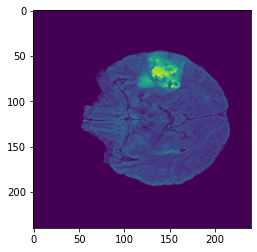

In [92]:
plt.figure()
plt.imshow(flair_rgb[:,:,60,0])
plt.show()

In [85]:
test_2d = flair_rgb[:,:,60,:]
test_2d.shape

(240, 240, 3)

In [89]:
slic = skimage.segmentation.slic(test_2d, n_segments=200, start_label=1)
slic.shape

(240, 240)

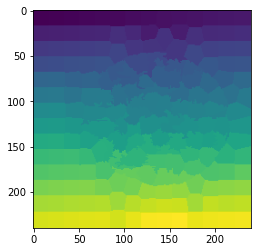

In [90]:
plt.figure()
plt.imshow(slic)
plt.show()

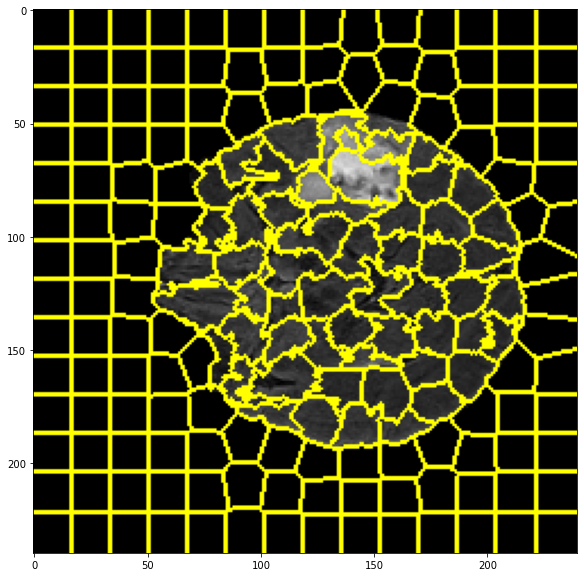

In [105]:
boundary_img = skimage.segmentation.mark_boundaries(test_2d, slic)
plt.figure(figsize=(10,10))
plt.imshow(boundary_img)
plt.show()

### 3d test

In [94]:
#convert to rGB color space
flair_rgb = gray2rgb(data_flair)
flair_rgb.shape

(240, 240, 155, 3)

In [101]:
slic_3d = skimage.segmentation.slic(flair_rgb, n_segments=1500, start_label=1)

In [102]:
slic_3d.shape

(240, 240, 155)

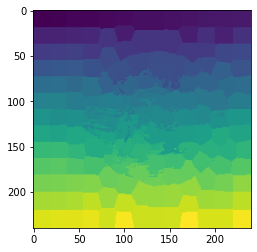

In [103]:
plt.figure()
plt.imshow(slic_3d[:,:,60])
plt.show()

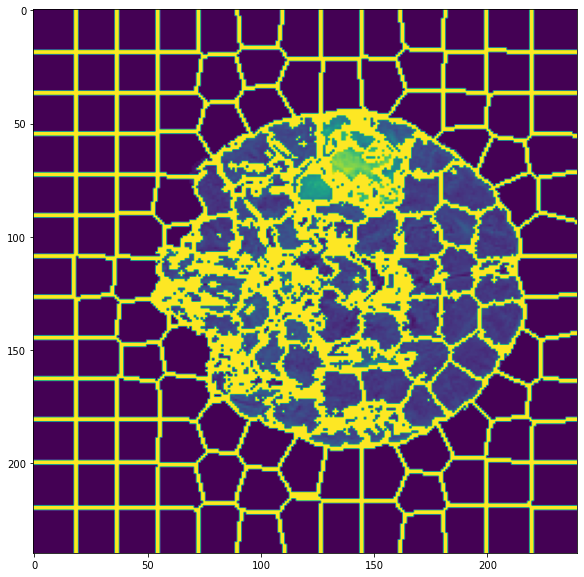

In [104]:
boundary_img = skimage.segmentation.mark_boundaries(flair_rgb, slic_3d)
plt.figure(figsize=(10,10))
plt.imshow(boundary_img[:,:,60,0])
plt.show()

In [46]:
data_seg, affine, im = load_nifti(sample_seg_path, return_img=True)
data_seg=data_seg/np.max(data_seg)

# FLAIR histogram
Want 4 humps: background, grey matter, white matter, tumor
"Best" results with 6 humps

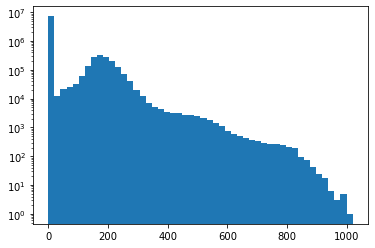

In [6]:
flair_flat = data_flair.flatten()
plt.figure()
plt.hist(flair_flat, bins=50, log=True)
plt.show()

### Do SLIC clustering

In [72]:
from skimage import data
img = data.immunohistochemistry()
img.shape

(512, 512, 3)

In [71]:
slic = skimage.segmentation.slic(img, n_segments=200, start_label=1)
slic.shape

(512, 512)

In [97]:
plt.figure()
plt.imshow(slic)
plt.show()

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

<Figure size 432x288 with 0 Axes>

In [75]:
boundary_img = skimage.segmentation.mark_boundaries(img, slic)

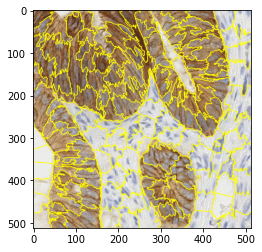

In [76]:
plt.figure()
plt.imshow(boundary_img)
plt.show()

In [62]:
segments = skimage.segmentation.slic(flair_rgb.T, n_segments=250, compactness=.04, sigma=1,
                     start_label=1)

In [63]:
segments

array([[[  1,   1,   1, ...,  16,  16,  16],
        [  1,   1,   1, ...,  16,  16,  16],
        [  1,   1,   1, ...,  16,  16,  16],
        ...,
        [220, 220, 220, ..., 224, 224, 224],
        [220, 220, 220, ..., 224, 224, 224],
        [220, 220, 220, ..., 224, 224, 224]],

       [[  1,   1,   1, ...,  16,  16,  16],
        [  1,   1,   1, ...,  16,  16,  16],
        [  1,   1,   1, ...,  16,  16,  16],
        ...,
        [220, 220, 220, ..., 224, 224, 224],
        [220, 220, 220, ..., 224, 224, 224],
        [220, 220, 220, ..., 224, 224, 224]],

       [[  1,   1,   1, ...,  16,  16,  16],
        [  1,   1,   1, ...,  16,  16,  16],
        [  1,   1,   1, ...,  16,  16,  16],
        ...,
        [220, 220, 220, ..., 224, 224, 224],
        [220, 220, 220, ..., 224, 224, 224],
        [220, 220, 220, ..., 224, 224, 224]]])

In [64]:
segments.shape

(3, 155, 240)

In [67]:
mark_boundaries(flair_rgb.T, segments)


ValueError: shape mismatch: value array of shape (3,) could not be broadcast to indexing result of shape (36858,240)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

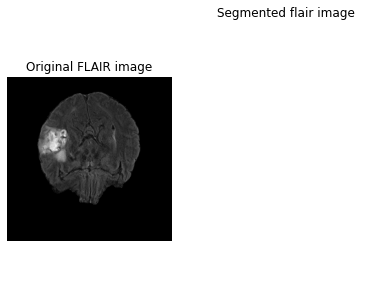

In [10]:

plt.figure(figsize=(10,5))

plt.subplot(1,3,1).set_axis_off()
plt.title("Original FLAIR image")
plt.imshow(data_flair[:,:,60].T, cmap="gray", origin='lower')

plt.subplot(1,3,2).set_axis_off()
plt.title("Segmented flair image")
plt.imshow(segments[:,:,60].T,  origin='lower')

plt.subplot(1,3,3).set_axis_off()
plt.title("Location of Tumor")
plt.imshow(segments[:,:,60].T, origin='lower')
plt.imshow(data_seg[:,:,60].T, alpha=0.8, cmap="gray", origin='lower')
plt.show()

## Calc mean and variance of clusters

In [9]:
def calc_mean_var(flair_2D, flair_kmeans, clusters):
    kmeans_arr=np.zeros((clusters, 3))
    for i in range(0, clusters):
        section=flair_2D[flair_kmeans==i]
        kmeans_arr[i]=np.array([i, np.mean(section), np.std(section)])
    return kmeans_arr

In [10]:
cluster_features = calc_mean_var(flair_2D, flair_kmeans, clusters)
cluster_features


array([[0.00000000e+00, 4.37035135e-01, 5.04311968e+00],
       [1.00000000e+00, 1.58660741e+02, 2.49831276e+01],
       [2.00000000e+00, 4.80696600e+02, 1.06495942e+02],
       [3.00000000e+00, 2.30350238e+02, 3.13463931e+01]])

### Which class has highest brightness?

In [11]:
tumor_label = np.argmax(cluster_features[:,1])
tumor_label

2

### See Mean calculation by hand

In [12]:
#Average of Class 0
np.mean(flair_2D[flair_kmeans==0])

0.43703513513810227

In [13]:
#Average of Class 1
np.mean(flair_2D[flair_kmeans==1])

158.66074133240147

In [14]:
#Average of Class 2
np.mean(flair_2D[flair_kmeans==2])

480.6966002604527

In [15]:
#Average of Class 3
np.mean(flair_2D[flair_kmeans==3])

230.35023787027367

### Visualize kmeans

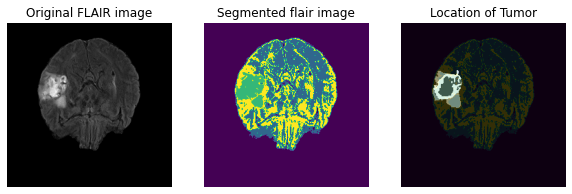

# Test accuracy of FLAIR segmentation
-not bad!

In [17]:
def evaluate_segmentation(flair_kmeans, data_seg, tumor_label):
    #coordinates of predicted and actual tumor
    y_coors = np.argwhere(data_seg.flatten()!=0)
    flair_yhat_coors = np.argwhere(flair_kmeans ==tumor_label)
    
    #size of tumor and non-tumor (number of voxels)
    tumor_size=len(y_coors)
    non_tumor_size = len(data_seg.flatten())-tumor_size

    #true positive
    correct_id_tumor = np.intersect1d(y_coors, flair_yhat_coors, assume_unique=True)
    percent_tumor_correct = len(correct_id_tumor)/tumor_size

    #false positive
    false_positive_points = np.setdiff1d(flair_yhat_coors, y_coors, assume_unique=True)
    false_positive = len(false_positive_points)/non_tumor_size

    #false negative
    false_neg_points = np.setdiff1d(y_coors, flair_yhat_coors, assume_unique=True)
    false_neg = len(false_neg_points)/tumor_size

    
    #true negative
    true_negative=(len(data_seg.flatten())-(tumor_size+len(false_positive_points)))/non_tumor_size

    #Total error (misidentification
    total_incorrect_points = np.concatenate((false_neg_points, false_positive_points))
    total_error = len(total_incorrect_points)/len(data_seg.flatten())
    
    print("True Positive: ", percent_tumor_correct)
    print("False negative: ", false_neg)
    print("True Negative: ", true_negative)
    print("False Positive: ", false_positive)
    
    print("************")
    print("Total Error: ", total_error)

In [18]:
evaluate_segmentation(flair_kmeans, data_seg, tumor_label)

True Positive:  0.6503391629366434
False negative:  0.34966083706335654
True Negative:  0.9991103765614838
False Positive:  0.0008896234385161477
************
Total Error:  0.0025827732974910396


# Working out accuracy matrix 
Information reflected in function above

### True tumor coordinates

In [19]:
np.argwhere(data_seg!=0)

array([[ 45, 138,  63],
       [ 45, 139,  63],
       [ 45, 140,  63],
       ...,
       [110, 138,  65],
       [110, 138,  66],
       [111, 137,  65]])

### True tumored coordinates on flattened data

In [20]:
y_coors = np.argwhere(data_seg.flatten()!=0)

### Size of tumor and non-tumor tissue

In [21]:
tumor_size=len(y_coors)
tumor_size

43342

In [22]:
non_tumor_size = len(data_seg.flatten())-tumor_size
non_tumor_size

8884658

## Predicted tumor coordinates

In [24]:
flair_yhat_coors = np.argwhere(flair_kmeans ==tumor_label)
len(flair_yhat_coors)

36091

### True positive

In [25]:
correct_id_tumor = np.intersect1d(y_coors, flair_yhat_coors, assume_unique=True)


In [26]:
percent_tumor_correct = len(correct_id_tumor)/tumor_size
percent_tumor_correct

0.6503391629366434

### False positive

In [27]:
false_positive_points = np.setdiff1d(flair_yhat_coors, y_coors, assume_unique=True)

In [28]:
false_positive = len(false_positive_points)/non_tumor_size
false_positive

0.0008896234385161477

### False Negative

In [29]:
false_neg_points = np.setdiff1d(y_coors, flair_yhat_coors, assume_unique=True)

In [30]:
false_neg = len(false_neg_points)/tumor_size
false_neg

0.34966083706335654

### True Negative

In [31]:
true_negative=(len(data_seg.flatten())-(tumor_size+len(false_positive_points)))/non_tumor_size
true_negative

0.9991103765614838

### Total misidentification

In [32]:
total_incorrect_points = np.concatenate((false_neg_points, false_positive_points))

In [33]:
total_error = len(total_incorrect_points)/len(data_seg.flatten())
total_error

0.0025827732974910396